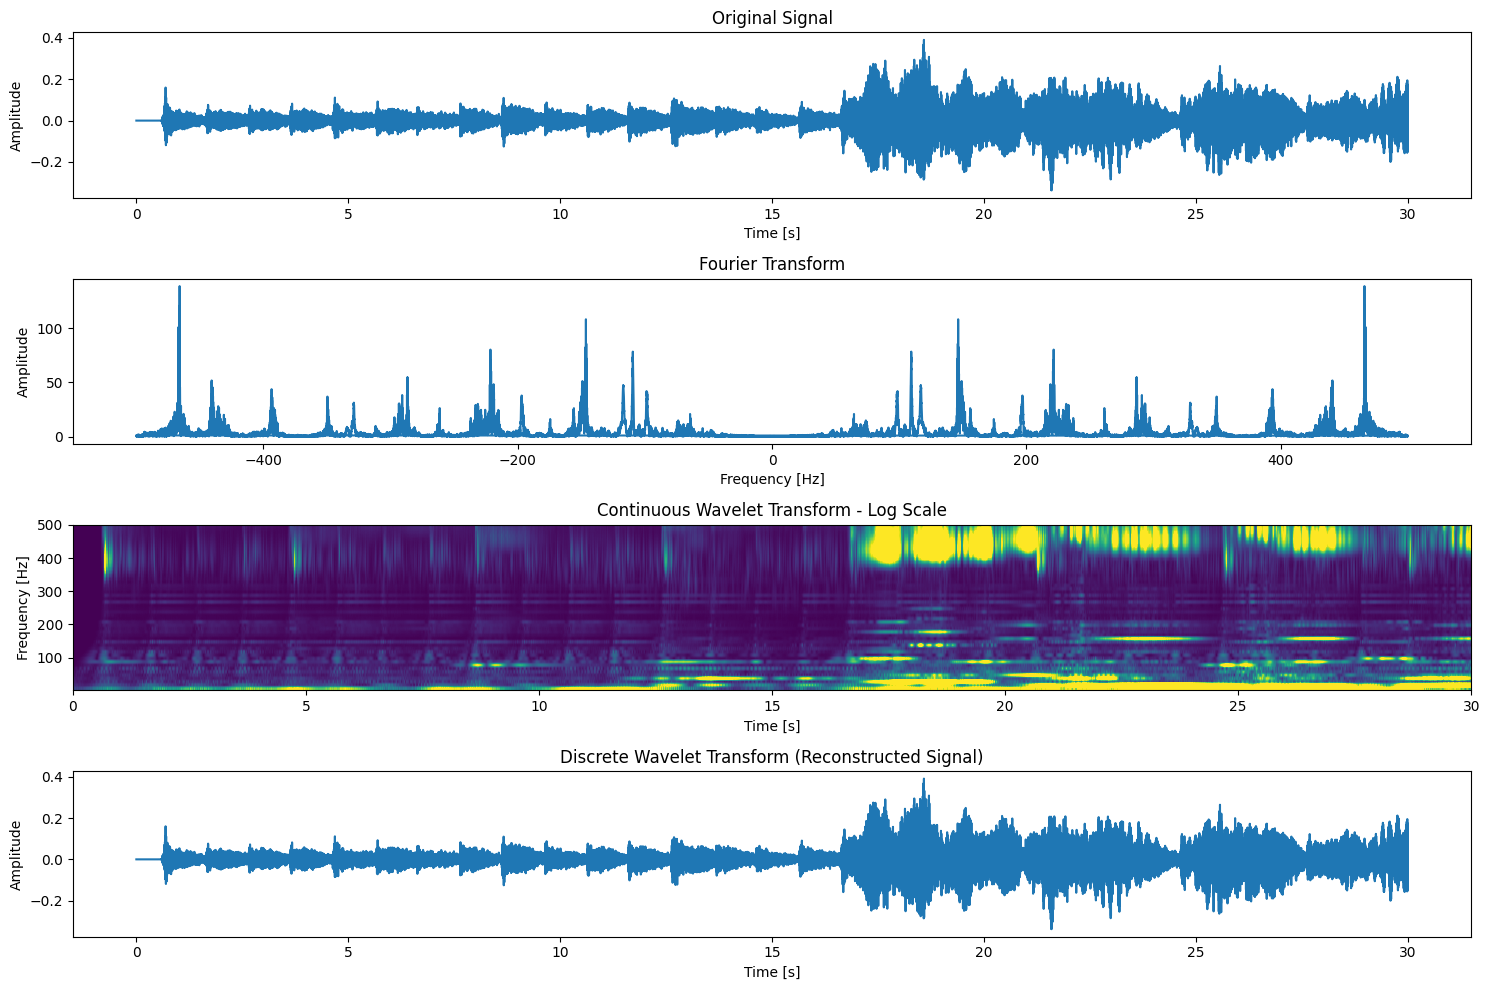

In [5]:
import soundfile as sf
import scipy.fft
import pywt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy import signal

def load_audio(file_path, sample_rate=1000, segment_length=30):
    audio, sr = sf.read(file_path)
    if sr != sample_rate:
        num_samples = int(len(audio) * float(sample_rate) / sr)
        audio = signal.resample(audio, num_samples)
    
    if audio.ndim > 1:
        audio_mono = np.mean(audio, axis=1)
    else:
        audio_mono = audio
    
    num_samples = segment_length * sample_rate
    return audio_mono[:num_samples], sample_rate

def analyze_time_series(data, sample_rate):
    # Fourier Transform
    fft_data = scipy.fft.fft(data)
    fft_freq = scipy.fft.fftfreq(len(data), 1/sample_rate)

    # Continuous Wavelet Transform (CWT)
    max_freq = sample_rate // 2
    widths = np.logspace(0, np.log10(max_freq), num=50)
    cwt_data, _ = pywt.cwt(data, widths, 'mexh')

    # Normalize CWT for better visualization using logarithmic scaling
    cwt_data_abs_log = np.log1p(np.abs(cwt_data))
    vmin, vmax = np.percentile(cwt_data_abs_log, [5, 95])

    # Discrete Wavelet Transform (DWT)
    coeffs = pywt.wavedec(data, 'db1', level=4)
    dwt_data = pywt.waverec(coeffs, 'db1')

    return fft_data, fft_freq, cwt_data_abs_log, vmin, vmax, dwt_data

def plot_analysis(data, sample_rate, fft_data, fft_freq, cwt_data_abs_log, vmin, vmax, dwt_data):
    t = np.linspace(0, len(data)/sample_rate, num=len(data))
    
    plt.figure(figsize=(15, 10))

    # Original Signal
    plt.subplot(4, 1, 1)
    plt.plot(t, data)
    plt.title('Original Signal')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')

    # Fourier Transform
    plt.subplot(4, 1, 2)
    plt.plot(fft_freq, np.abs(fft_data))
    plt.title('Fourier Transform')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude')

    # Continuous Wavelet Transform
    plt.subplot(4, 1, 3)
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    plt.imshow(cwt_data_abs_log, extent=[0, len(data)/sample_rate, 1, sample_rate//2], cmap='viridis', aspect='auto', norm=norm)
    plt.title('Continuous Wavelet Transform - Log Scale')
    plt.xlabel('Time [s]')
    plt.ylabel('Frequency [Hz]')

    # Discrete Wavelet Transform
    plt.subplot(4, 1, 4)
    plt.plot(t, dwt_data)
    plt.title('Discrete Wavelet Transform (Reconstructed Signal)')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

def analyze_audio(file_path, segment_length=30, sample_rate=1000):
    data, sr = load_audio(file_path, sample_rate, segment_length)
    fft_data, fft_freq, cwt_data_abs_log, vmin, vmax, dwt_data = analyze_time_series(data, sr)
    plot_analysis(data, sr, fft_data, fft_freq, cwt_data_abs_log, vmin, vmax, dwt_data)

file_path = "./Guilty Hero.mp3"
analyze_audio(file_path)

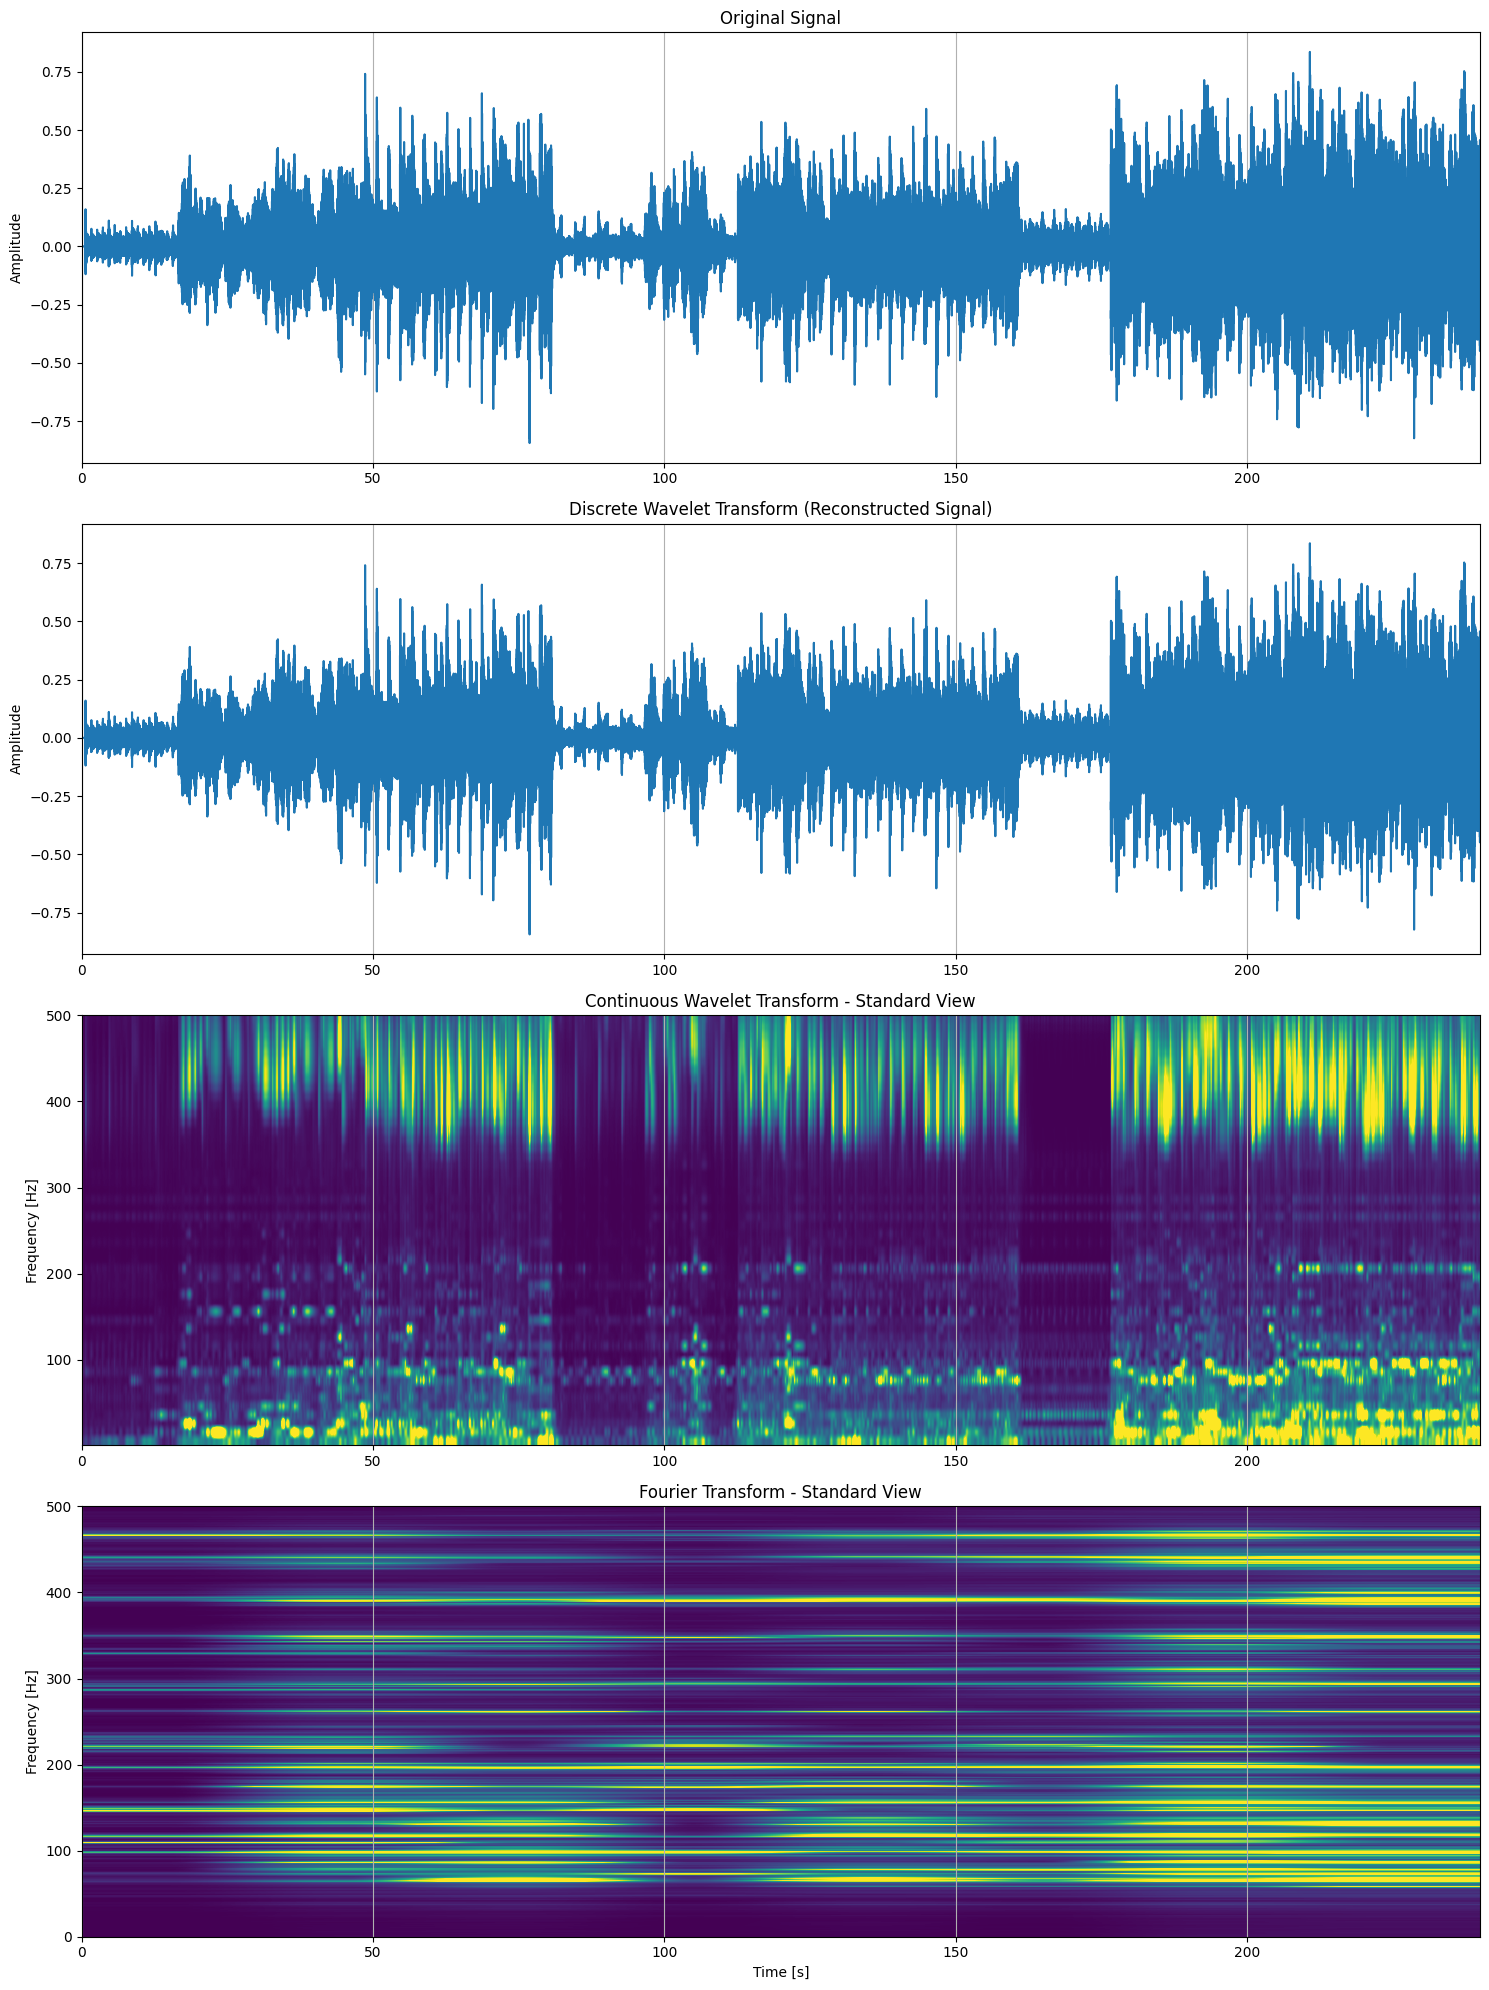

In [6]:
import soundfile as sf
import scipy.fft
import pywt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy import signal

def load_audio(file_path, sample_rate=1000):
    audio, sr = sf.read(file_path)
    if sr != sample_rate:
        num_samples = int(len(audio) * float(sample_rate) / sr)
        audio = signal.resample(audio, num_samples)
    
    if audio.ndim > 1:
        audio_mono = np.mean(audio, axis=1)
    else:
        audio_mono = audio
    
    return audio_mono, sample_rate

def chunk_data(data, segment_length, sample_rate):
    chunk_size = segment_length * sample_rate
    num_chunks = len(data) // chunk_size
    return [data[i*chunk_size:(i+1)*chunk_size] for i in range(num_chunks)]


def analyze_time_series(chunks, sample_rate):
    results = []
    fft_freq = scipy.fft.fftfreq(len(chunks[0]), 1/sample_rate)
    for chunk in chunks:
        fft_data = scipy.fft.fft(chunk)
        max_freq = sample_rate // 2
        widths = np.logspace(0, np.log10(max_freq), num=50)
        cwt_data, _ = pywt.cwt(chunk, widths, 'mexh')
        cwt_data_abs_log = np.log1p(np.abs(cwt_data))
        coeffs = pywt.wavedec(chunk, 'db1', level=4)
        dwt_data = pywt.waverec(coeffs, 'db1')
        results.append((fft_data, cwt_data_abs_log, dwt_data))
    return results, fft_freq

def plot_analysis(chunks, sample_rate, results, fft_freq, segment_length):
    total_time = len(chunks) * len(chunks[0]) / sample_rate
    time = np.linspace(0, total_time, len(np.concatenate(chunks)))

    fig, axs = plt.subplots(4, 1, figsize=(15, 20), sharex=True)
    
    # Original Signal
    axs[0].plot(time, np.concatenate(chunks))
    axs[0].set_title('Original Signal')
    axs[0].set_ylabel('Amplitude')

    # Continuous Wavelet Transform
    cwt_data = np.concatenate([result[1] for result in results], axis=1)
    vmin, vmax = np.percentile(cwt_data, [5, 95])
    axs[1].imshow(cwt_data, extent=[0, total_time, 1, sample_rate//2], 
                  cmap='viridis', aspect='auto', norm=colors.Normalize(vmin=vmin, vmax=vmax))
    axs[1].set_title('Continuous Wavelet Transform - Log Scale')
    axs[1].set_ylabel('Frequency [Hz]')

    # Discrete Wavelet Transform
    dwt_data = np.concatenate([result[2] for result in results])
    axs[2].plot(time, dwt_data)
    axs[2].set_title('Discrete Wavelet Transform (Reconstructed Signal)')
    axs[2].set_ylabel('Amplitude')

    # Fourier Transform chunk by chunk
    num_chunks = len(results)
    fft_data = [np.abs(result[0][:len(fft_freq)//2]) for result in results]
    max_amplitude = max(np.max(chunk) for chunk in fft_data)
    
    for i, chunk in enumerate(fft_data):
        start = i * segment_length
        end = (i + 1) * segment_length
        axs[3].plot(fft_freq[:len(fft_freq)//2] + i * (sample_rate/2), chunk)
        axs[3].axvline(x=(i+1) * (sample_rate/2), color='r', linestyle='--', alpha=0.5)
    
    axs[3].set_title('Fourier Transform (chunk by chunk)')
    axs[3].set_xlabel('Frequency [Hz]')
    axs[3].set_ylabel('Amplitude')
    axs[3].set_xlim(0, num_chunks * (sample_rate/2))
    axs[3].set_ylim(0, max_amplitude)

    plt.tight_layout()
    plt.show()

def plot_analysis(chunks, sample_rate, results, fft_freq, segment_length, viz_mode='standard'):
    total_time = len(chunks) * len(chunks[0]) / sample_rate
    time = np.linspace(0, total_time, len(np.concatenate(chunks)))

    # Define percentile ranges for different visualization modes
    percentile_ranges = {
        'standard': (5, 95),
        'enhanced_contrast': (1, 99),
        'outlier_inclusive': (0.1, 99.9),
        'extreme_outlier': (0.01, 99.99)
    }
    
    lower_percentile, upper_percentile = percentile_ranges.get(viz_mode, (5, 95))

    fig, axs = plt.subplots(4, 1, figsize=(15, 20))
    
    # Original Signal
    axs[0].plot(time, np.concatenate(chunks))
    axs[0].set_title('Original Signal')
    axs[0].set_ylabel('Amplitude')
    axs[0].set_xlim(0, total_time)
    axs[0].grid(axis='x')

    # Discrete Wavelet Transform
    dwt_data = np.concatenate([result[2] for result in results])
    axs[1].plot(time, dwt_data)
    axs[1].set_title('Discrete Wavelet Transform (Reconstructed Signal)')
    axs[1].set_ylabel('Amplitude')
    axs[1].set_xlim(0, total_time)
    axs[1].grid(axis='x')

    # Continuous Wavelet Transform
    cwt_data = np.concatenate([result[1] for result in results], axis=1)
    vmin, vmax = np.percentile(cwt_data, [lower_percentile, upper_percentile])
    axs[2].imshow(cwt_data, extent=[0, total_time, 1, sample_rate//2], 
                  cmap='viridis', aspect='auto', norm=colors.Normalize(vmin=vmin, vmax=vmax))
    axs[2].set_title(f'Continuous Wavelet Transform - {viz_mode.replace("_", " ").title()} View')
    axs[2].set_ylabel('Frequency [Hz]')
    axs[2].set_xlim(0, total_time)
    axs[2].grid(axis='x')

# Fourier Transform
    fft_data = [np.abs(result[0][:len(fft_freq)//2]) for result in results]
    fft_matrix = np.array(fft_data).T
    extent = [0, total_time, 0, sample_rate/2]
    vmin, vmax = np.percentile(fft_matrix, [lower_percentile, upper_percentile])
    im = axs[3].imshow(fft_matrix, aspect='auto', extent=extent, origin='lower', 
                    cmap='viridis', norm=colors.Normalize(vmin=vmin, vmax=vmax))
    axs[3].set_title(f'Fourier Transform - {viz_mode.replace("_", " ").title()} View')
    axs[3].set_xlabel('Time [s]')
    axs[3].set_ylabel('Frequency [Hz]')
    axs[3].set_xlim(0, total_time)
    axs[3].grid(axis='x')


    plt.tight_layout()
    plt.show()

def analyze_audio(file_path, segment_length=30, sample_rate=1000, viz_mode='standard'):
    data, sr = load_audio(file_path, sample_rate)
    chunks = chunk_data(data, segment_length, sr)
    results, fft_freq = analyze_time_series(chunks, sr)
    plot_analysis(chunks, sr, results, fft_freq, segment_length, viz_mode)



file_path = "./Guilty Hero.mp3"
analyze_audio(file_path, viz_mode='standard')

In [2]:
import pandas as pd
import io
import re

def count_blank_lines_and_get_content(file_path):
    blank_lines = 0
    content = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.strip() == '':
                blank_lines += 1
            else:
                content.append(line.strip())
                if len(content) == 3:  # We only need the first 3 non-blank lines
                    break
    return blank_lines, content

def parse_line(line):
    return re.split(r'\s{2,}|\t', line.strip())

def parse_asc_file(file_path):
    blank_lines, content = count_blank_lines_and_get_content(file_path)
    
    # Parse header
    header = parse_line(content[0])
    
    # Parse units (if available)
    units = parse_line(content[1])
    units = [''] * 2 + units  # Add empty strings for first two columns

    # Combine header and units
    header_with_units = [f"{h} ({u})" if u else h for h, u in zip(header, units)]

    
    # Read the data
    data = []
    with open(file_path, 'r') as file:
        for i, line in enumerate(file):
            if i < blank_lines + 2:  # Skip blank lines, header, and units
                continue
            row = line.split()
            # Ensure the number of columns in each row matches the header
            if len(row) > len(header_with_units):
                row = row[:len(header_with_units)]
            elif len(row) < len(header_with_units):
                row.extend([''] * (len(header_with_units) - len(row)))
            data.append(row)
    
    # Create DataFrame
    df = pd.DataFrame(data, columns=header_with_units)
    
    # Convert numeric columns to float
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='ignore')
    
    return df
    

# Usage
file_path = "c:/development/signal-processing/data/Shell_P1ST1/ASCII/Time_Ascii/Sep2014/Prelude P1 ST1_Time_Ascii_16-09-2014.ASC"
df = parse_asc_file(file_path)

# Display the first few rows of the dataframe
print(df.head())

# Display information about the dataframe
print(df.info())

C:\Users\sonpn\AppData\Local\Temp\ipykernel_18184\1021459519.py:54: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


         Date      Time  Bit Depth (m)  Tot Depth (m)  TVD Depth (m)  \
0  09-16-2014  00:00:10        4730.05        4731.35        4070.13   
1  09-16-2014  00:00:20        4730.05        4731.35        4070.13   
2  09-16-2014  00:00:30        4730.05        4731.35        4070.13   
3  09-16-2014  00:00:40        4730.05        4731.35        4070.13   
4  09-16-2014  00:00:50        4730.05        4731.35        4070.13   

   LAG Depth (m)  WOH (klbs)  WOH min (klbs)  WOH max (klbs)  WOB (klbs)  ...  \
0         4717.0       163.7           164.7           164.7         0.0  ...   
1         4717.0       163.6           162.9           162.9         0.0  ...   
2         4717.0       163.9           164.2           164.2         0.0  ...   
3         4717.0       164.5           164.0           164.0         0.0  ...   
4         4717.0       163.4           163.1           163.1         0.0  ...   

   RETURN (%)  Sum 1 (bbl)  VarSum1 (l/mn)  ACT PIT (bbl)  VarSum2 (l/mn)  \
0  

In [4]:
# Combine Date and Time columns into one column datetime
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df = df.drop(['Date', 'Time'], axis=1)
df_signal_analysis = df[['datetime', 'TORQUE (lb*ft)']].copy()
df_signal_analysis.set_index('datetime', inplace=True)

# How to define if the datetime in df_signal_analysis has the const sample rate
# Calculate the time difference between consecutive rows
time_diff = df_signal_analysis.index.to_series().diff()
# Check if the time difference is constant
is_constant_sample_rate = time_diff.nunique() == 1
# Print the result
print("Is the sample rate constant?", is_constant_sample_rate)
print(time_diff.unique())




Is the sample rate constant? True
<TimedeltaArray>
[NaT, '0 days 00:00:10']
Length: 2, dtype: timedelta64[ns]


C:\Users\sonpn\AppData\Local\Temp\ipykernel_17868\1406689711.py:70: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')
C:\Users\sonpn\AppData\Local\Temp\ipykernel_17868\1406689711.py:193: RuntimeWarning: divide by zero encountered in log10
  widths = np.logspace(0, np.log10(max_freq), num=128)
c:\Users\sonpn\anaconda3\envs\signal_processing\lib\site-packages\numpy\_core\function_base.py:168: RuntimeWarning: invalid value encountered in multiply
  y *= step
c:\Users\sonpn\anaconda3\envs\signal_processing\lib\site-packages\pywt\_functions.py:183: RuntimeWarning: divide by zero encountered in divide
  return central_frequency(wavelet, precision=precision) / scale


ValueError: zero-size array to reduction operation minimum which has no identity

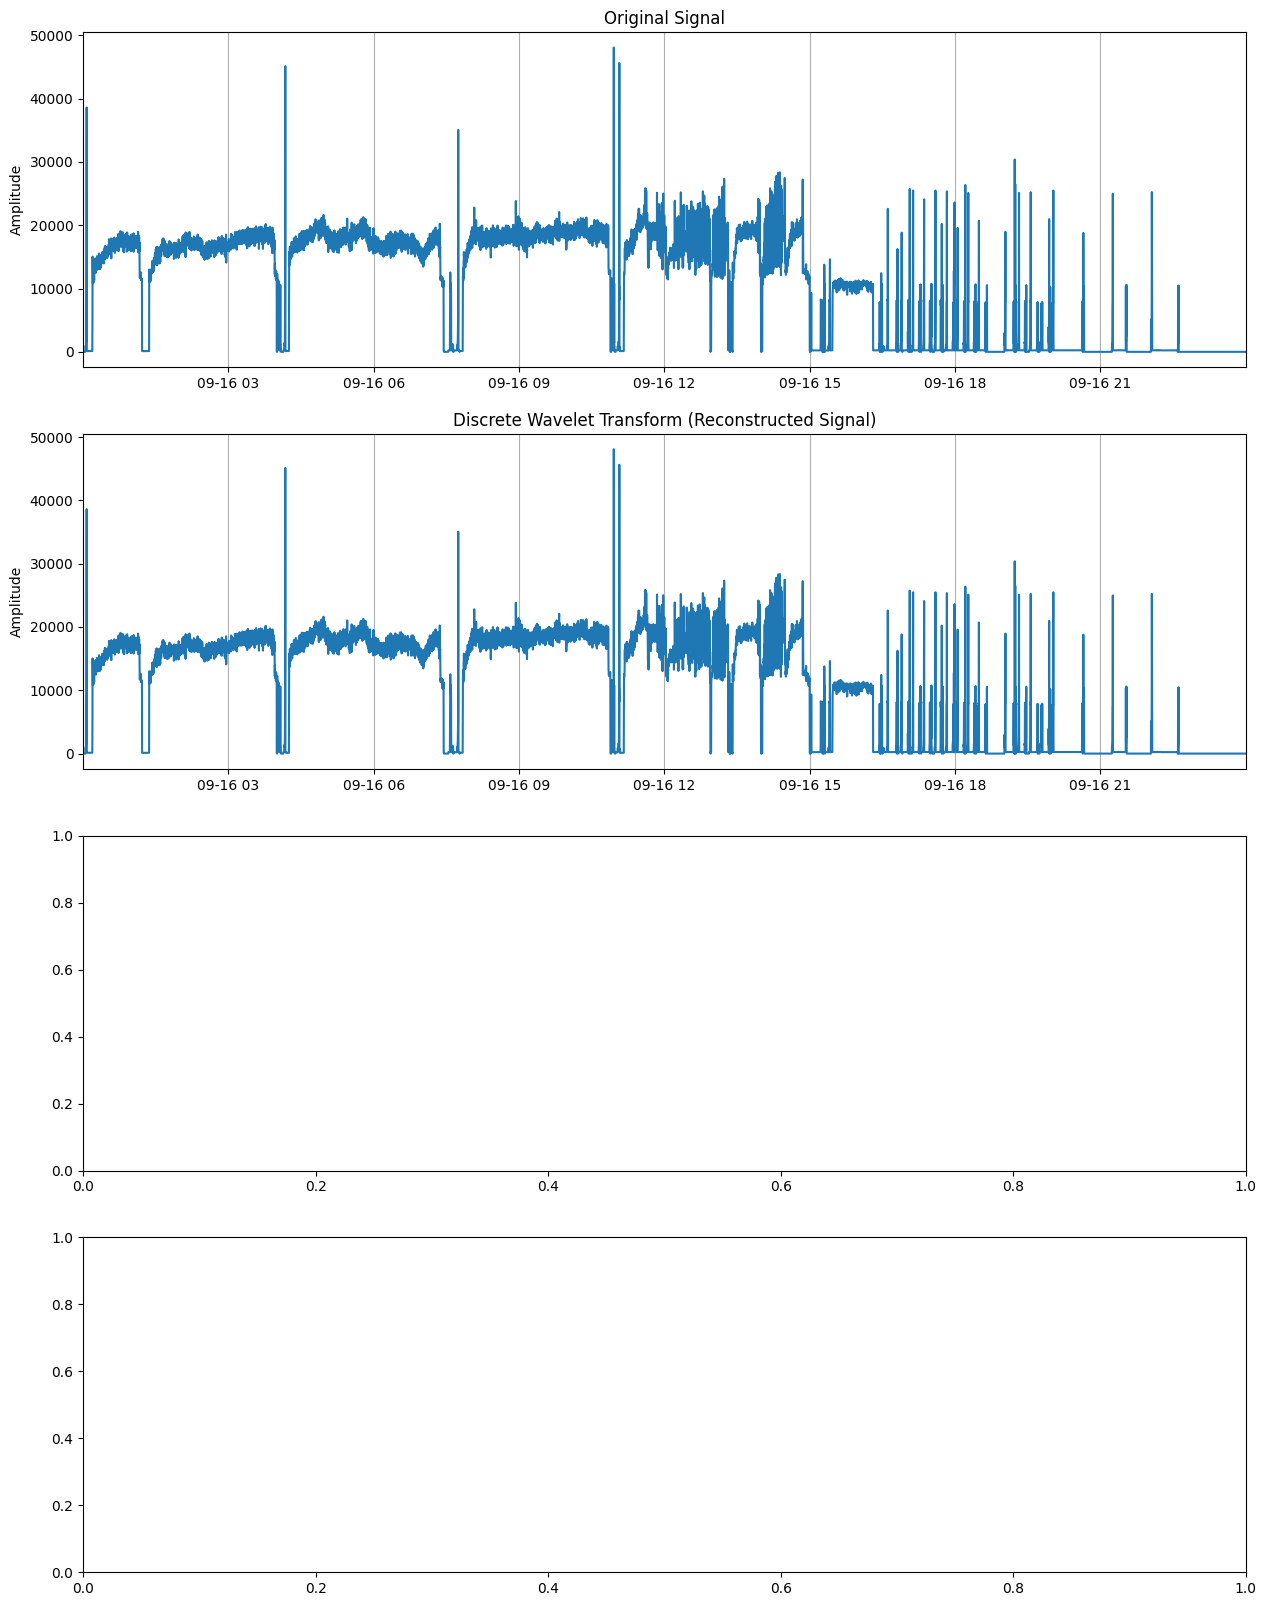

In [2]:
import pandas as pd
import io
import re
import numpy as np
import pandas as pd
from scipy.fft import fft, fftfreq
import pywt
import matplotlib.pyplot as plt
import matplotlib.colors as colors
def count_blank_lines_and_get_content(file_path):
    blank_lines = 0
    content = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.strip() == '':
                blank_lines += 1
            else:
                content.append(line.strip())
                if len(content) == 3:  # We only need the first 3 non-blank lines
                    break
    return blank_lines, content

def parse_line(line):
    return re.split(r'\s{2,}|\t', line.strip())

def parse_asc_file(file_path):
    blank_lines, content = count_blank_lines_and_get_content(file_path)
    
    # Parse header
    header = parse_line(content[0])
    
    # Parse units (if available)
    units = parse_line(content[1])
    units = [''] * 2 + units  # Add empty strings for first two columns

    # Combine header and units
    header_with_units = [f"{h} ({u})" if u else h for h, u in zip(header, units)]

    
    # Read the data
    data = []
    with open(file_path, 'r') as file:
        for i, line in enumerate(file):
            if i < blank_lines + 2:  # Skip blank lines, header, and units
                continue
            row = line.split()
            # Ensure the number of columns in each row matches the header
            if len(row) > len(header_with_units):
                row = row[:len(header_with_units)]
            elif len(row) < len(header_with_units):
                row.extend([''] * (len(header_with_units) - len(row)))
            data.append(row)
    
    # Create DataFrame
    df = pd.DataFrame(data, columns=header_with_units)
    
    # print("After load dataframe from ASC file")
    # print(df.head())

    # Create datetime column from Date and Time columns
    df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
    df = df.drop(['Date', 'Time'], axis=1)
    
    # Convert datetime col into datetime type
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)

    # Convert numeric columns to float
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='ignore')
    
    
    return df
    
def extract_datetime_data_from_df(df, data_col):
    df_extracted = df[[data_col]].copy()

    return df_extracted

def analyze_time_series_data(df, segment_length=3600, viz_mode='standard'):
    # Ensure the index is datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index, unit='s')

    # Calculate sample rate
    time_diff = df.index.to_series().diff().mean().total_seconds()
    sample_rate = 1 / time_diff

    # Calculate number of samples per segment
    samples_per_segment = int(segment_length * sample_rate)

    # Chunk the data
    chunks = [df.iloc[i:i+samples_per_segment, 0].values for i in range(0, len(df), samples_per_segment)]

    results, fft_freq = analyze_time_series(chunks, sample_rate)
    plot_analysis(chunks, sample_rate, results, fft_freq, segment_length, viz_mode, df.index)


def analyze_time_series(chunks, sample_rate):
    results = []
    for chunk in chunks:
        # FFT (unchanged)
        fft_result = fft(chunk)
        fft_freq = fftfreq(len(chunk), 1/sample_rate)

        # CWT (updated)
        max_freq = sample_rate // 2
        widths = np.logspace(0, np.log10(max_freq), num=50)
        cwt_result, _ = pywt.cwt(chunk, widths, 'mexh')
        cwt_result_abs_log = np.log1p(np.abs(cwt_result))

        # DWT (unchanged)
        wavelet = 'db4'
        level = pywt.dwt_max_level(len(chunk), pywt.Wavelet(wavelet).dec_len)
        coeffs = pywt.wavedec(chunk, wavelet, level=level)
        dwt_result = pywt.waverec(coeffs, wavelet)

        # Ensure DWT result has the same length as the input (unchanged)
        if len(dwt_result) > len(chunk):
            dwt_result = dwt_result[:len(chunk)]
        elif len(dwt_result) < len(chunk):
            dwt_result = np.pad(
                dwt_result, (0, len(chunk) - len(dwt_result)), 'constant')

        results.append((fft_result, cwt_result_abs_log, dwt_result))

    return results, fft_freq



def analyze_time_series(chunks, sample_rate):
    results = []
    for chunk in chunks:
        # FFT (unchanged)
        fft_result = fft(chunk)
        fft_freq = fftfreq(len(chunk), 1/sample_rate)

        # CWT (updated)
        scales = np.logspace(0, 7, num=128, base=2)
        cwt_result, _ = pywt.cwt(chunk, scales, 'morl', 1/sample_rate)

        # DWT (unchanged)
        wavelet = 'db4'
        level = pywt.dwt_max_level(len(chunk), pywt.Wavelet(wavelet).dec_len)
        coeffs = pywt.wavedec(chunk, wavelet, level=level)
        dwt_result = pywt.waverec(coeffs, wavelet)

        # Ensure DWT result has the same length as the input (unchanged)
        if len(dwt_result) > len(chunk):
            dwt_result = dwt_result[:len(chunk)]
        elif len(dwt_result) < len(chunk):
            dwt_result = np.pad(
                dwt_result, (0, len(chunk) - len(dwt_result)), 'constant')

        results.append((fft_result, cwt_result, dwt_result))

    return results, fft_freq


def plot_analysis(chunks, sample_rate, results, fft_freq, segment_length, viz_mode='standard', timestamps=None):
    total_time = (timestamps[-1] - timestamps[0]).total_seconds()
    time = timestamps

    # Define percentile ranges for different visualization modes
    percentile_ranges = {
        'standard': (5, 95),
        'enhanced_contrast': (1, 99),
        'outlier_inclusive': (0.1, 99.9),
        'extreme_outlier': (0.01, 99.99)
    }
    
    lower_percentile, upper_percentile = percentile_ranges.get(viz_mode, (5, 95))

    fig, axs = plt.subplots(4, 1, figsize=(15, 20))
    
    # Original Signal
    axs[0].plot(time, np.concatenate(chunks))
    axs[0].set_title('Original Signal')
    axs[0].set_ylabel('Amplitude')
    axs[0].set_xlim(timestamps[0], timestamps[-1])
    axs[0].grid(axis='x')

    # Discrete Wavelet Transform
    dwt_data = np.concatenate([result[2] for result in results])
    axs[1].plot(time, dwt_data)
    axs[1].set_title('Discrete Wavelet Transform (Reconstructed Signal)')
    axs[1].set_ylabel('Amplitude')
    axs[1].set_xlim(timestamps[0], timestamps[-1])
    axs[1].grid(axis='x')

    # Continuous Wavelet Transform
    max_freq = sample_rate // 2
    widths = np.logspace(0, np.log10(max_freq), num=128)
    frequencies = pywt.scale2frequency('mexh', widths) * sample_rate
    
    frequencies = frequencies[np.isfinite(frequencies)]


    cwt_matrix = np.zeros((len(widths), len(timestamps)))
    for i, result in enumerate(results):
        start_idx = i * len(chunks[0])
        end_idx = start_idx + len(chunks[0])
        cwt_matrix[:, start_idx:end_idx] = result[1]

    vmin, vmax = np.percentile(cwt_matrix, [5, 95])
    im = axs[2].imshow(cwt_matrix, extent=[timestamps[0], timestamps[-1], np.min(frequencies), np.max(frequencies)],
                    cmap='viridis', aspect='auto', norm=colors.Normalize(vmin=vmin, vmax=vmax),
                    origin='lower')

    axs[2].set_title('Continuous Wavelet Transform - Log Scale')
    axs[2].set_ylabel('Frequency [Hz]')
    axs[2].set_ylim(frequencies[-1], frequencies[0])
    axs[2].set_xlim(timestamps[0], timestamps[-1])
    axs[2].grid(axis='x')


    # Fourier Transform
    fft_data = [np.abs(result[0][:len(fft_freq)//2]) for result in results]
    fft_matrix = np.array(fft_data).T
    extent = [timestamps[0], timestamps[-1], 0, sample_rate/2]
    vmin, vmax = np.percentile(fft_matrix, [lower_percentile, upper_percentile])
    im = axs[3].imshow(fft_matrix, aspect='auto', extent=extent, origin='lower',
                    cmap='viridis', norm=colors.Normalize(vmin=vmin, vmax=vmax))
    axs[3].set_title(f'Fourier Transform - {viz_mode.replace("_", " ").title()} View')
    axs[3].set_xlabel('Time')
    axs[3].set_ylabel('Frequency [Hz]')
    axs[3].set_xlim(timestamps[0], timestamps[-1])
    axs[3].grid(axis='x')

    plt.tight_layout()
    plt.show()


# Usage
file_path = "c:/development/signal-processing/data/Shell_P1ST1/ASCII/Time_Ascii/Sep2014/Prelude P1 ST1_Time_Ascii_16-09-2014.ASC"
df = parse_asc_file(file_path)

datetime_col = 'datetime'
data_col = 'TRQ max (lb*ft)'

# Assuming you have already created df_extracted
df_extracted = extract_datetime_data_from_df(df, data_col)

# Analyze and plot the time series data
analyze_time_series_data(df_extracted, viz_mode='standard')

C:\Users\sonpn\AppData\Local\Temp\ipykernel_17868\1908179037.py:74: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


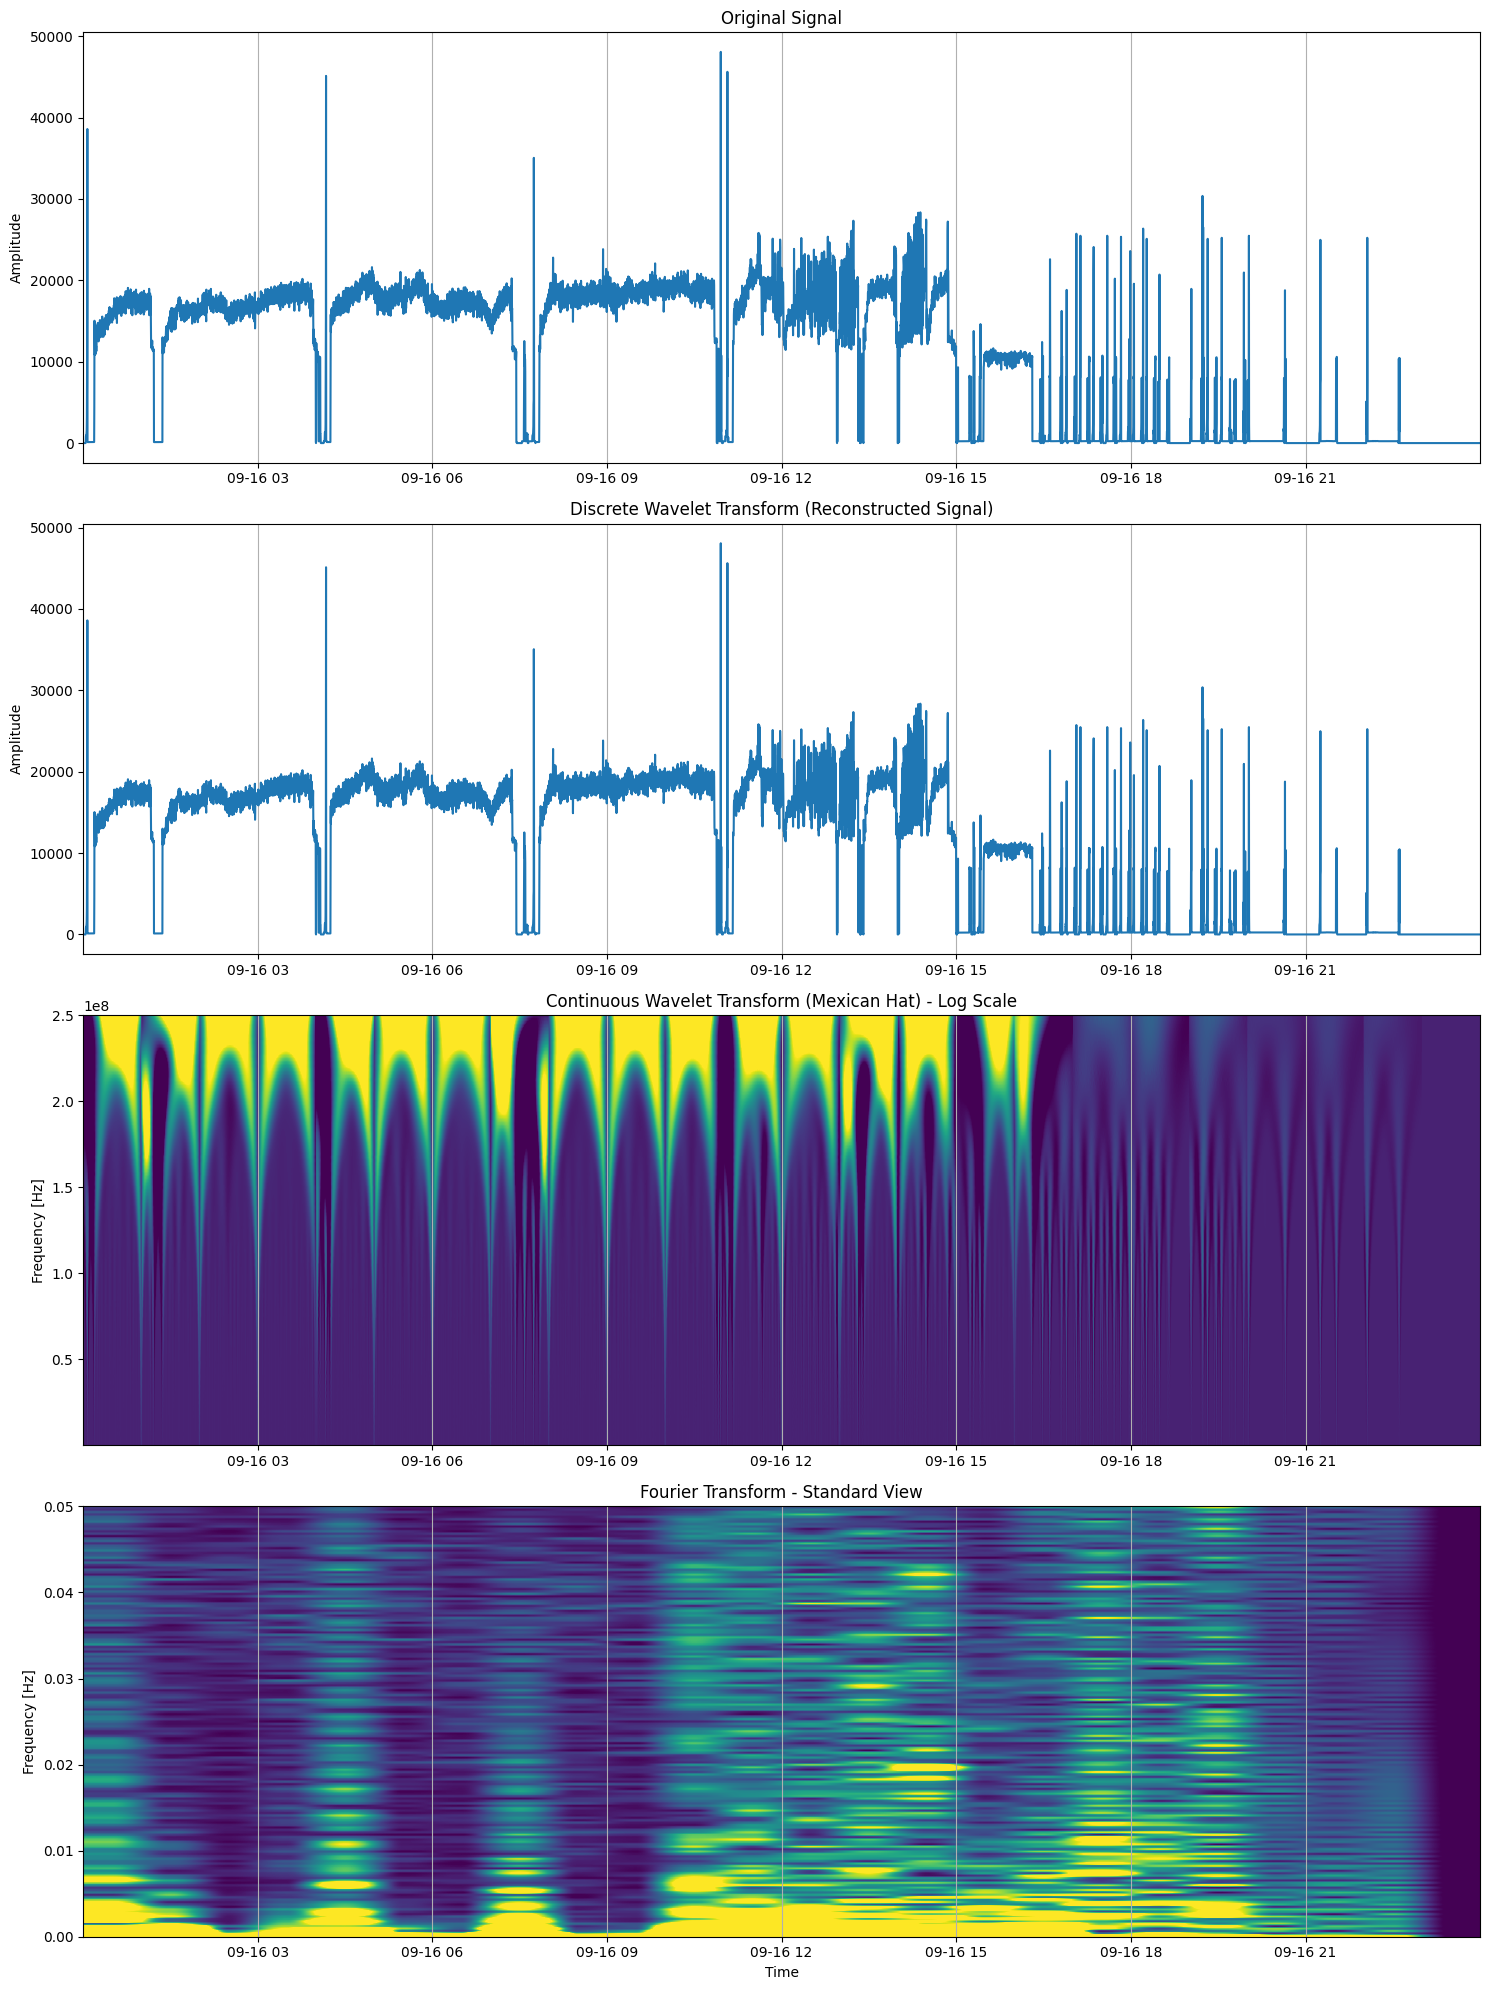

In [6]:
import pandas as pd
import io
import re
import numpy as np
import pandas as pd
from scipy.fft import fft, fftfreq
import pywt
import matplotlib.pyplot as plt
import matplotlib.colors as colors


def count_blank_lines_and_get_content(file_path):
    blank_lines = 0
    content = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.strip() == '':
                blank_lines += 1
            else:
                content.append(line.strip())
                if len(content) == 3:  # We only need the first 3 non-blank lines
                    break
    return blank_lines, content


def parse_line(line):
    return re.split(r'\s{2,}|\t', line.strip())


def parse_asc_file(file_path):
    blank_lines, content = count_blank_lines_and_get_content(file_path)

    # Parse header
    header = parse_line(content[0])

    # Parse units (if available)
    units = parse_line(content[1])
    units = [''] * 2 + units  # Add empty strings for first two columns

    # Combine header and units
    header_with_units = [
        f"{h} ({u})" if u else h for h, u in zip(header, units)]

    # Read the data
    data = []
    with open(file_path, 'r') as file:
        for i, line in enumerate(file):
            if i < blank_lines + 2:  # Skip blank lines, header, and units
                continue
            row = line.split()
            # Ensure the number of columns in each row matches the header
            if len(row) > len(header_with_units):
                row = row[:len(header_with_units)]
            elif len(row) < len(header_with_units):
                row.extend([''] * (len(header_with_units) - len(row)))
            data.append(row)

    # Create DataFrame
    df = pd.DataFrame(data, columns=header_with_units)

    # print("After load dataframe from ASC file")
    # print(df.head())

    # Create datetime column from Date and Time columns
    df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
    df = df.drop(['Date', 'Time'], axis=1)

    # Convert datetime col into datetime type
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)

    # Convert numeric columns to float
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='ignore')

    return df

def analyze_time_series_data(df, segment_length=3600, viz_mode='standard'):
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index, unit='s')

    time_diff = df.index.to_series().diff().mean().total_seconds()
    sample_rate = 1 / time_diff

    samples_per_segment = int(segment_length * sample_rate)

    chunks = [df.iloc[i:i+samples_per_segment,
                      0].values for i in range(0, len(df), samples_per_segment)]

    results, fft_freq = analyze_time_series(chunks, sample_rate)
    plot_analysis(chunks, sample_rate, results, fft_freq,
                  segment_length, viz_mode, df.index)


def analyze_time_series(chunks, sample_rate):
    results = []
    for chunk in chunks:
        fft_result = fft(chunk)
        fft_freq = fftfreq(len(chunk), 1/sample_rate)

        scales = np.logspace(0, 7, num=128, base=2)
        # Changed to 'mexh' for Mexican hat wavelet
        cwt_result, _ = pywt.cwt(chunk, scales, 'mexh', 1/sample_rate)

        wavelet = 'db4'
        level = pywt.dwt_max_level(len(chunk), pywt.Wavelet(wavelet).dec_len)
        coeffs = pywt.wavedec(chunk, wavelet, level=level)
        dwt_result = pywt.waverec(coeffs, wavelet)

        if len(dwt_result) > len(chunk):
            dwt_result = dwt_result[:len(chunk)]
        elif len(dwt_result) < len(chunk):
            dwt_result = np.pad(
                dwt_result, (0, len(chunk) - len(dwt_result)), 'constant')

        results.append((fft_result, cwt_result, dwt_result))

    return results, fft_freq


def plot_analysis(chunks, sample_rate, results, fft_freq, segment_length, viz_mode='standard', timestamps=None):
    total_time = (timestamps[-1] - timestamps[0]).total_seconds()
    time = timestamps

    percentile_ranges = {
        'standard': (5, 95),
        'enhanced_contrast': (1, 99),
        'outlier_inclusive': (0.1, 99.9),
        'extreme_outlier': (0.01, 99.99)
    }

    lower_percentile, upper_percentile = percentile_ranges.get(
        viz_mode, (5, 95))

    fig, axs = plt.subplots(4, 1, figsize=(15, 20))

    axs[0].plot(time, np.concatenate(chunks))
    axs[0].set_title('Original Signal')
    axs[0].set_ylabel('Amplitude')
    axs[0].set_xlim(timestamps[0], timestamps[-1])
    axs[0].grid(axis='x')

    dwt_data = np.concatenate([result[2] for result in results])
    axs[1].plot(time, dwt_data)
    axs[1].set_title('Discrete Wavelet Transform (Reconstructed Signal)')
    axs[1].set_ylabel('Amplitude')
    axs[1].set_xlim(timestamps[0], timestamps[-1])
    axs[1].grid(axis='x')

    max_freq = max(sample_rate // 2, 1e-10)
    scales = np.logspace(0, np.log10(max_freq), num=128)

    try:
        frequencies = pywt.scale2frequency('mexh', scales) * sample_rate
        frequencies = frequencies[np.isfinite(frequencies) & (frequencies > 0)]
    except Exception:
        frequencies = np.array([])

    if len(frequencies) > 0:
        cwt_matrix = np.zeros((len(scales), len(timestamps)))
        for i, result in enumerate(results):
            start_idx = i * len(chunks[0])
            end_idx = start_idx + len(chunks[0])
            cwt_matrix[:, start_idx:end_idx] = result[1]

        vmin, vmax = np.percentile(cwt_matrix, [5, 95])
        im = axs[2].imshow(cwt_matrix, extent=[timestamps[0], timestamps[-1], np.min(frequencies), np.max(frequencies)],
                           cmap='viridis', aspect='auto', norm=colors.Normalize(vmin=vmin, vmax=vmax),
                           origin='lower')
        axs[2].set_title(
            'Continuous Wavelet Transform (Mexican Hat) - Log Scale')
        axs[2].set_ylabel('Frequency [Hz]')
        axs[2].set_ylim(np.min(frequencies), np.max(frequencies))
        axs[2].set_xlim(timestamps[0], timestamps[-1])
        axs[2].grid(axis='x')
    else:
        axs[2].text(0.5, 0.5, 'No valid frequency data',
                    ha='center', va='center')
        axs[2].set_title('Continuous Wavelet Transform - No Data')

    fft_data = [np.abs(result[0][:len(fft_freq)//2]) for result in results]
    fft_matrix = np.array(fft_data).T
    extent = [timestamps[0], timestamps[-1], 0, sample_rate/2]
    vmin, vmax = np.percentile(
        fft_matrix, [lower_percentile, upper_percentile])
    im = axs[3].imshow(fft_matrix, aspect='auto', extent=extent, origin='lower',
                       cmap='viridis', norm=colors.Normalize(vmin=vmin, vmax=vmax))
    axs[3].set_title(
        f'Fourier Transform - {viz_mode.replace("_", " ").title()} View')
    axs[3].set_xlabel('Time')
    axs[3].set_ylabel('Frequency [Hz]')
    axs[3].set_xlim(timestamps[0], timestamps[-1])
    axs[3].grid(axis='x')

    plt.tight_layout()
    plt.show()


# Usage
file_path = "c:/development/signal-processing/data/Shell_P1ST1/ASCII/Time_Ascii/Sep2014/Prelude P1 ST1_Time_Ascii_16-09-2014.ASC"
df = parse_asc_file(file_path)

datetime_col = 'datetime'
data_col = 'TRQ max (lb*ft)'

df_extracted = extract_datetime_data_from_df(df, data_col)

analyze_time_series_data(df_extracted, viz_mode='standard')

In [ ]:
df.columns

Index(['Bit Depth (m)', 'Tot Depth (m)', 'TVD Depth (m)', 'LAG Depth (m)',
       'WOH (klbs)', 'WOH min (klbs)', 'WOH max (klbs)', 'WOB (klbs)',
       'TORQUE (lb*ft)', 'TRQ min (lb*ft)', 'TRQ max (lb*ft)', 'RPM (rpm)',
       'SPP (psi)', 'ROP m/hr (m/h)', 'Cntr 1 (stks)', 'Pump 1 (spm)',
       'Cntr 2 (stks)', 'Pump 2 (spm)', 'Cntr 3 (stks)', 'Pump 3 (spm)',
       'Cum Cntrs (stks)', 'PumpTime (h)', 'FLWpmps (gpm)', 'RETURN (%)',
       'Sum 1 (bbl)', 'VarSum1 (l/mn)', 'ACT PIT (bbl)', 'VarSum2 (l/mn)',
       'MW IN (ppg)', 'MW OUT (kg/l)', 'TMP IN (degC)',
       'TMP OUT T GAS main T GAS main T GAS main T GAS main (degC)',
       'T Revol (%)'],
      dtype='object')

In [ ]:
df.columns

Index(['Bit Depth (m)', 'Tot Depth (m)', 'TVD Depth (m)', 'LAG Depth (m)',
       'WOH (klbs)', 'WOH min (klbs)', 'WOH max (klbs)', 'WOB (klbs)',
       'TORQUE (lb*ft)', 'TRQ min (lb*ft)', 'TRQ max (lb*ft)', 'RPM (rpm)',
       'SPP (psi)', 'ROP m/hr (m/h)', 'Cntr 1 (stks)', 'Pump 1 (spm)',
       'Cntr 2 (stks)', 'Pump 2 (spm)', 'Cntr 3 (stks)', 'Pump 3 (spm)',
       'Cum Cntrs (stks)', 'PumpTime (h)', 'FLWpmps (gpm)', 'RETURN (%)',
       'Sum 1 (bbl)', 'VarSum1 (l/mn)', 'ACT PIT (bbl)', 'VarSum2 (l/mn)',
       'MW IN (ppg)', 'MW OUT (kg/l)', 'TMP IN (degC)',
       'TMP OUT T GAS main T GAS main T GAS main T GAS main (degC)',
       'T Revol (%)'],
      dtype='object')